<a href="https://colab.research.google.com/github/ace26597/Covid-Tweet-Analysis-and-Recommendation/blob/main/Covid_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Data/Covid_NLP/Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('/content/drive/MyDrive/Colab Data/Covid_NLP/Corona_NLP_test.csv',encoding='latin1')

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
train.shape

(41157, 6)

In [ ]:
train.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [ ]:
test.describe()

,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [ ]:
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
test.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

# Data Analysis

In [ ]:
dist_train = train['Sentiment'].value_counts()
dist_test = test['Sentiment'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

ditribution_plot(x= dist_train.index, y= dist_train.values, name= 'Class Distribution train')
ditribution_plot(x= dist_test.index, y= dist_test.values, name= 'Class Distribution test')


In [ ]:
df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)

class_df = df.groupby('Sentiment').count()['text'].reset_index().sort_values(by='Sentiment',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Sentiment,text
4,Positive,12369
3,Neutral,8332
2,Negative,10958
1,Extremely Positive,7223
0,Extremely Negative,6073


In [ ]:
from plotly.subplots import make_subplots
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.Sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.Sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

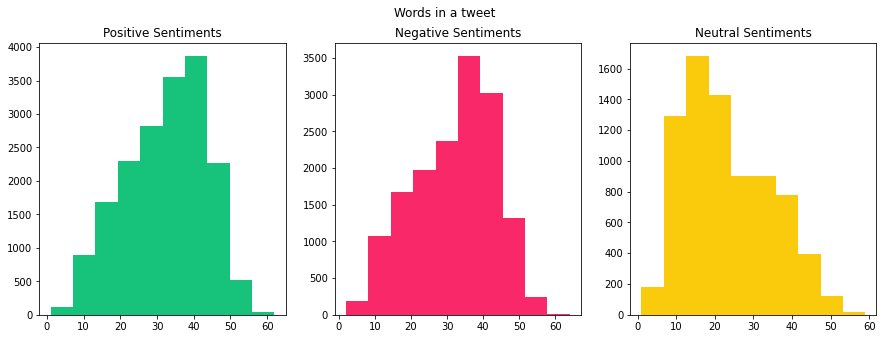

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

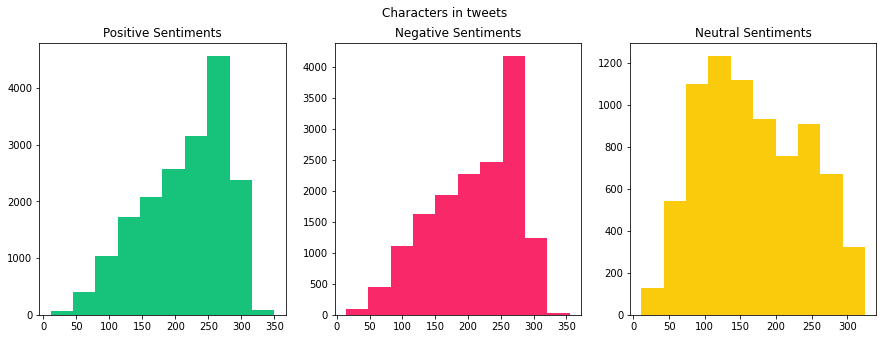

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

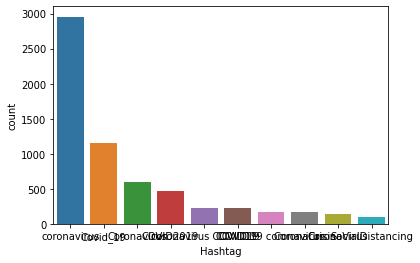

In [ ]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

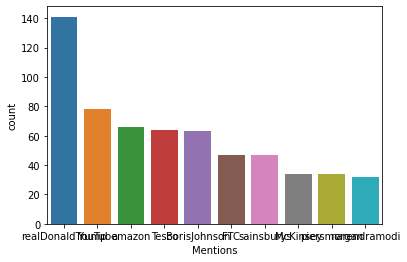

In [ ]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)

In [ ]:
!pip install geopandas

In [ ]:
train['Sentiment']

0                   Neutral
1                  Positive
2                  Positive
3                  Positive
4        Extremely Negative
                ...        
41152               Neutral
41153    Extremely Negative
41154              Positive
41155               Neutral
41156              Negative
Name: Sentiment, Length: 41157, dtype: object

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   text           41157 non-null  object
 7   sentiment      41157 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


In [ ]:
train['OriginalTweet']

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

In [ ]:
train['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

# Data Preprocessing

In [ ]:
nltk.download('words')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')  

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [ ]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(X[6]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 36117

Example:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1174, 7, 4, 1269, 761, 65, 2902, 9761, 9762, 154, 18316, 1501, 2, 62, 154, 900, 958]

After padding :
[ 1174     7     4  1269   761    65  2902  9761  9762   154 18316  1501
     2    62   154   900   958     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [ ]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']
           

y.replace(encoding, inplace=True)

In [ ]:
X.shape

(41157, 54)

In [ ]:
y.isnull().sum()

0

# Model

## SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectors = vectorizer.fit_transform(X_cleaned)

In [ ]:
test_vectors = vectors[40000:]
train_vectors = vectors[:40000]

from sklearn import svm
from sklearn.metrics import classification_report
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, y[:40000])
prediction_linear = classifier_linear.predict(test_vectors)


In [ ]:
# results
print("Results for SVC(kernel=linear)")
report = classification_report(y[40000:], prediction_linear, output_dict=True)
print('positive: ', report['0'])
print('negative: ', report['1'])
print('notr: ', report['2'])

Results for SVC(kernel=linear)
positive:  {'precision': 0.8471177944862155, 'recall': 0.8325123152709359, 'f1-score': 0.8397515527950311, 'support': 406}
negative:  {'precision': 0.8209606986899564, 'recall': 0.8068669527896996, 'f1-score': 0.8138528138528139, 'support': 233}
notr:  {'precision': 0.8714555765595463, 'recall': 0.88996138996139, 'f1-score': 0.8806112702960841, 'support': 518}


## LSTM

In [ ]:
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 3
BATCH_SIZE = 32
embedding_dim = 16
units = 256

#define model
model = tf.keras.Sequential([
    Layers.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    #pooling data in to 1D
    Layers.Dropout(0.4),
    #DROPOUT  for avoid overfitting
    Layers.Dense(64, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
    #output layer i.e 3
])

#compile model
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            577872    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [ ]:
X.shape

(41157, 54)

In [ ]:
y.shape

(41157,)

In [ ]:
#dependent var = y = sentiment column
#X = independent vairable = all cols- sentiment
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE)

fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

Epoch 1/3
1029/1029 [==============================] - 362s 348ms/step - loss: 0.9168 - accuracy: 0.5035 - val_loss: 0.4692 - val_accuracy: 0.8354
Epoch 2/3
1029/1029 [==============================] - 355s 345ms/step - loss: 0.3921 - accuracy: 0.8691 - val_loss: 0.3654 - val_accuracy: 0.8786
Epoch 3/3
1029/1029 [==============================] - 354s 344ms/step - loss: 0.2446 - accuracy: 0.9240 - val_loss: 0.3937 - val_accuracy: 0.8647


In [ ]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

pred = model.predict_classes(X_test)

loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Test loss: 0.44282400608062744
Test Accuracy: 0.850710928440094


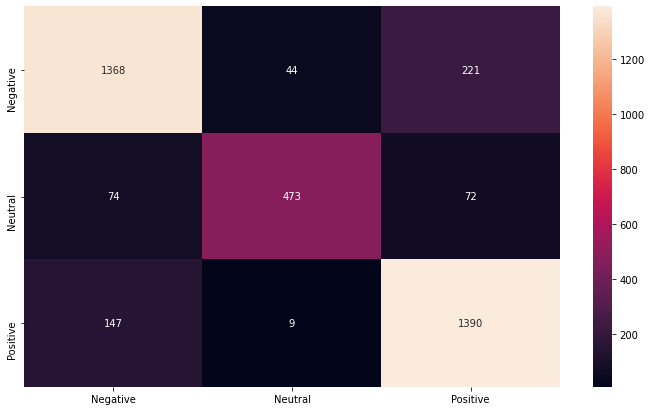

              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      1633
     Neutral       0.90      0.76      0.83       619
    Positive       0.83      0.90      0.86      1546

    accuracy                           0.85      3798
   macro avg       0.86      0.83      0.85      3798
weighted avg       0.85      0.85      0.85      3798



In [ ]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(classification_report(y_test, pred, target_names=labels))

In [ ]:
"""train["lat"] = np.nan
train["lon"] = np.nan
for i in range(len(train)):
  if pd.isna(train['Location'][i]) == True:
    print('Nan')
    continue
  try:
    location = geolocator.geocode(train['Location'][i], timeout=None)
    train['lat'][i] =location.latitude
    train['lon'][i] = location.longitude
  except:
    continue
    train.to_csv('train.csv')
"""


'train["lat"] = np.nan\ntrain["lon"] = np.nan\nfor i in range(len(train)):\n  if pd.isna(train[\'Location\'][i]) == True:\n    print(\'Nan\')\n    continue\n  try:\n    location = geolocator.geocode(train[\'Location\'][i], timeout=None)\n    train[\'lat\'][i] =location.latitude\n    train[\'lon\'][i] = location.longitude\n  except:\n    continue\n    train.to_csv(\'train.csv\')\n'

In [ ]:
"""test["lat"] = np.nan
test["lon"] = np.nan
for i in range(len(test)):
  if pd.isna(test['Location'][i]) == True:
    continue
  try:
    location = geolocator.geocode(test['Location'][i], timeout=None)
    test['lat'][i] =location.latitude
    test['lon'][i] = location.longitude
  except:
    continue
test.to_csv('test.csv')"""

'test["lat"] = np.nan\ntest["lon"] = np.nan\nfor i in range(len(test)):\n  if pd.isna(test[\'Location\'][i]) == True:\n    continue\n  try:\n    location = geolocator.geocode(test[\'Location\'][i], timeout=None)\n    test[\'lat\'][i] =location.latitude\n    test[\'lon\'][i] = location.longitude\n  except:\n    continue\ntest.to_csv(\'test.csv\')'

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Data/Covid_NLP/train.csv',encoding='latin1')
test = pd.read_csv('/content/drive/MyDrive/Colab Data/Covid_NLP/test.csv',encoding='latin1')

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning:

Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



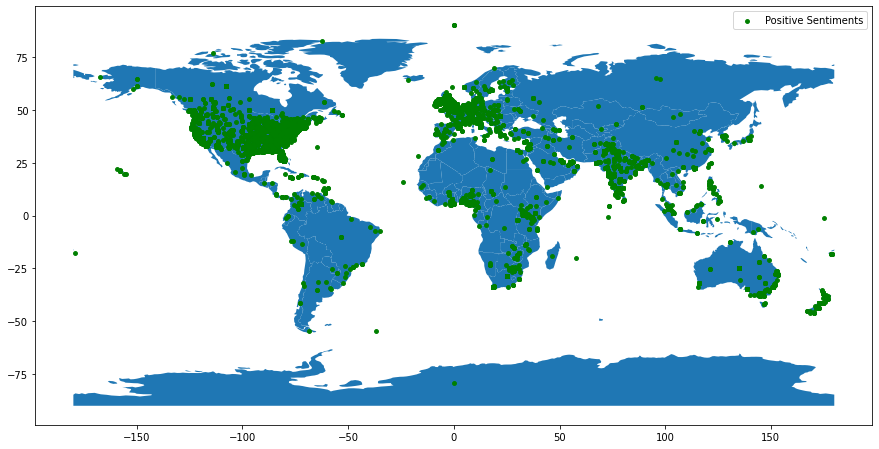

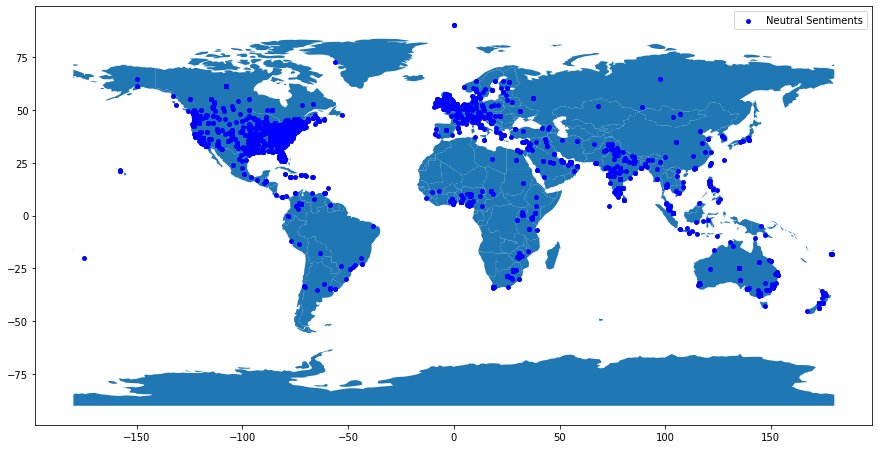

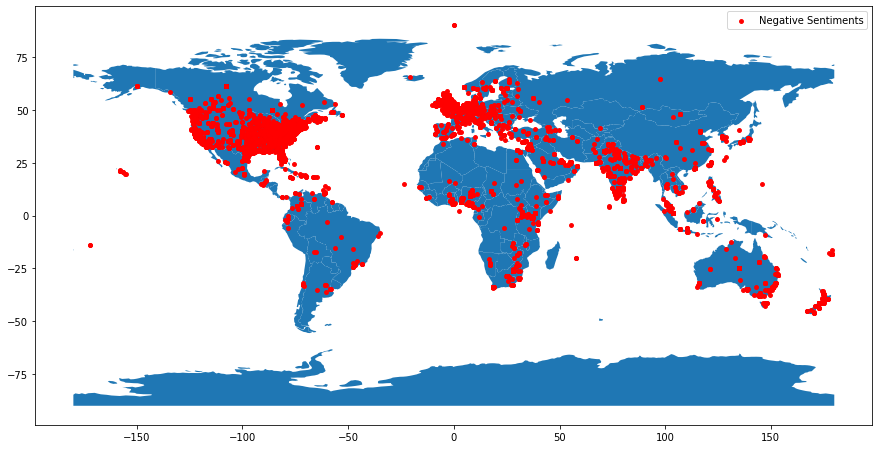

In [ ]:
positive_df = train[(train["Sentiment"] == "Positive")|(train["Sentiment"] == "Extremely Positive")].dropna()
positive_df = positive_df[["lat","lon"]]

neutral_df = train[(train["Sentiment"] == "Neutral")].dropna()
neutral_df = neutral_df[["lat","lon"]]

negative_df = train[(train["Sentiment"] == "Negative")|(train["Sentiment"] == "Extremely Negative")].dropna()
negative_df = negative_df[["lat","lon"]]

# let's look at the csse daily data
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
geolocator = Nominatim()

geometry = [Point(xy) for xy in zip(positive_df['lon'], positive_df['lat'])]
gdf_pos = GeoDataFrame(positive_df[['lat','lon']], geometry=geometry)   

geometry = [Point(xy) for xy in zip(neutral_df['lon'], neutral_df['lat'])]
gdf_net = GeoDataFrame(neutral_df[['lat','lon']], geometry=geometry)   

geometry = [Point(xy) for xy in zip(negative_df['lon'], negative_df['lat'])]
gdf_neg = GeoDataFrame(negative_df[['lat','lon']], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_pos.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='green',label="Positive Sentiments", markersize=15);
plt.legend()
gdf_net.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='blue',label="Neutral Sentiments", markersize=15);
plt.legend()
gdf_neg.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='red',label="Negative Sentiments", markersize=15);
plt.legend()